In [1]:
import os
import pickle
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm import tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
save_path = os.path.join('..', 'data', f'bert_embeds.pkl')
X = []
with open(save_path, 'rb') as f:
    X = pickle.load(f)

# list(map(lambda x: x.shape, bert_embeds))

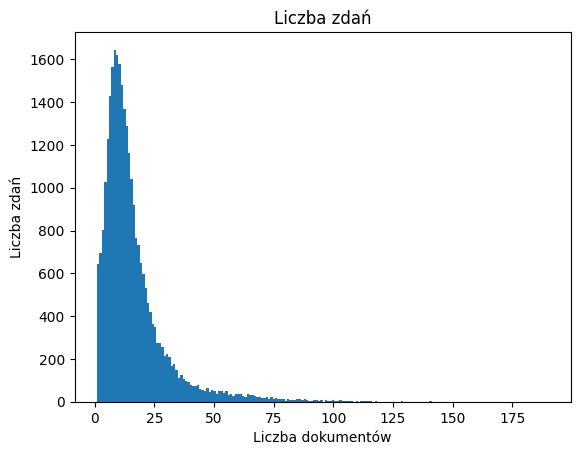

In [4]:
import matplotlib.pyplot as plt

seq_length = [p.shape[0] for p in X]

plt.title('Liczba zdań')
plt.xlabel('Liczba dokumentów')
plt.ylabel('Liczba zdań')
plt.hist(seq_length, bins = max(seq_length));

In [5]:
'median', int(torch.tensor(seq_length).median().cpu())

('median', 12)

In [6]:
'avg', torch.tensor(seq_length).sum() / len(seq_length)

('avg', tensor(15.8155))

In [7]:
'max length',max(seq_length)

('max length', 190)

In [8]:
sentence_limit = 20
padder = torch.nn.functional.pad

In [9]:
def get_to_same_length(tensor_list):
    new_tensor_list = []
    for t in tqdm(tensor_list):
        t = t[:sentence_limit]

        if t.shape[0] < sentence_limit:
            p2d = (0, 0, 0, sentence_limit - t.shape[0]) 
            t = torch.nn.functional.pad(t, p2d)

        new_tensor_list.append(t)
    return new_tensor_list

In [10]:
X = torch.stack(get_to_same_length(X))

100%|██████████| 28533/28533 [00:03<00:00, 8704.30it/s] 


In [11]:
seq_length = (X.sum(dim=2) != 0).sum(dim=1)

In [12]:
df = pd.read_csv(os.path.join('..', 'data', 'final_recipes.csv'), sep=';')
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit([[d] for d in df['category']])
y = enc.transform([[d] for d in df['category']]).toarray()
y = torch.Tensor(y)
y = torch.argmax(y, dim = 1)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, seq_len_train, seq_len_val = train_test_split( X, y, seq_length,test_size=0.33, random_state=42, stratify=y)

In [14]:
train_dataset = TensorDataset(X_train.to(device), y_train.to(device), seq_len_train.to(device))
val_dataset = TensorDataset(X_test.to(device), y_test.to(device), seq_len_val.to(device))

In [15]:

batch_size = 32
# batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L

# torch.manual_seed(1)

In [17]:
class LSTMClassifier(L.LightningModule):

    def __init__(self, embedding_dim, hidden_dim, layers, target_size, loss_f, do_std = False):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        # self.batch_norm = nn.BatchNorm1d(20)
        
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim // 2, layers, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dim // 2, hidden_dim // 4, layers, batch_first=True)

        self.hidden2class = nn.Linear(hidden_dim , target_size)

        self.activate = nn.Softmax(dim=1)
        
        self.loss_f = loss_f

        self.do_std = do_std
        self.std_init = False
        self.mean = torch.nn.parameter.Parameter(torch.zeros(embedding_dim), requires_grad=False)
        self.std = torch.nn.parameter.Parameter(torch.zeros(embedding_dim), requires_grad=False)

    def init_norm_scaler(self, train_dl):

        dt = train_dl.dataset[:][0]

        one_big_sequence = torch.concat(list(dt))
        one_big_sequence = one_big_sequence[one_big_sequence.sum(dim=1) != 0]

        m = one_big_sequence.mean(0, keepdim=True)
        s = one_big_sequence.std(0, keepdim=True)

        self.mean.data = m
        self.std.data = s

        self.std_init = True

    def forward(self, embeds, seq_len):
        if self.do_std and not self.std_init:
            raise Exception('Normal scaler not initialized')
        
        if self.do_std:
            
            embeds -= self.mean
            embeds /= self.std
        
        # embeds = self.batch_norm(embeds)

        pack = torch.nn.utils.rnn.pack_padded_sequence(embeds, seq_len.cpu(), batch_first=True, enforce_sorted=False)
        
        out, _ = self.lstm1(pack)
        # out, _ = self.lstm2(out)
        # out, _ = self.lstm3(out)
        
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)

        indicies = (unpacked_len - 1).detach().cpu().numpy().tolist()

        out = unpacked[range(unpacked.shape[0]), indicies,:]

        pred = self.hidden2class(out)
        pred = self.activate(pred)
        return pred
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x_b, y_b, seq_len = batch

        
        pred = self.forward(x_b, seq_len)
        
        loss = self.loss_f(pred, y_b)

        self.log("train/loss", loss)
        self.log("train/acc", self.get_accuracy(pred, y_b))
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_b, y_b, seq_len = batch

        pred = self.forward(x_b, seq_len)
        
        loss = self.loss_f(pred, y_b)

        self.log("val/loss", loss)
        self.log("val/acc", self.get_accuracy(pred, y_b))

    def get_accuracy(self, preds, labels):
        pr = torch.argmax(preds, dim=1)
        return (pr.cpu() == labels.cpu()).float().sum() / preds.shape[0]

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-5) #5
        return optimizer

In [18]:
class_counts = pd.DataFrame(y_train).value_counts().sort_index()

In [19]:
max_cnt = max(class_counts)

In [20]:
weights = [max_cnt / class_counts[c] for c in range(torch.unique(y).shape[0])]
class_weights = torch.FloatTensor(weights).cuda()

# class_weights = class_weights.cpu().apply_(lambda x: max(1., x / 2)) # reduced weights
# class_weights=None

In [21]:
epochs = 5000
# loss_f = torch.nn.CrossEntropyLoss(weight=class_weights)
loss_f = torch.nn.NLLLoss(weight=class_weights)
clf = LSTMClassifier(embedding_dim = 1024, 
                     hidden_dim = 128, 
                     layers = 3, 
                     target_size = 16, 
                     loss_f=loss_f,
                     do_std=False
                     ).to(device)

if clf.do_std:
    clf.init_norm_scaler(train_dl=train_dataloader)

In [22]:
x_b, y_b, seq_len = val_dataset[0:1]
clf(x_b, seq_len)

tensor([[0.0687, 0.0600, 0.0696, 0.0594, 0.0650, 0.0654, 0.0664, 0.0607, 0.0635,
         0.0651, 0.0579, 0.0599, 0.0587, 0.0595, 0.0585, 0.0616]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [23]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

trainer = L.Trainer(max_epochs=epochs,
                    #  callbacks=[EarlyStopping(monitor="val/loss", mode="min", patience=5)]
                     )
trainer.fit(clf, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type    | Params
-----------------------------------------
0 | lstm1        | LSTM    | 855 K 
1 | lstm2        | LSTM    | 116 K 
2 | lstm3        | LSTM    | 29.4 K
3 | hidden2class | Linear  | 2.1 K 
4 | activate     | Softmax | 0     
5 | loss_f       | NLLLoss | 0     
  | other params | n/a     | 2.0 K 
-----------------------------------------
1.0 M     Trainable params
2.0 K     Non-trainable params
1.0 M     Total params
4.019     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Todd Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Todd Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\Todd Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [24]:
clf=clf.to(device)

In [25]:
import os
import sys
sys.path.append(os.path.split(os.getcwd())[0])
from utils.plot_utils import plot_matrix

In [26]:
import time
predictions = []
labels = []
time_taken = []
for x,y, l in val_dataloader:
    start = time.time()
    predictions+= torch.argmax(clf(x,l), dim = 1).cpu().detach().numpy().tolist()
    time_taken.append((time.time() - start) / x.shape[0])
    labels += y.cpu().detach().numpy().tolist()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions, output_dict = True, zero_division=0, target_names=enc.categories_[0])
#report_df = pd.DataFrame.from_dict(report, orient='index')
df = pd.DataFrame(report).transpose()
df = df[df['support'] != 4.0]
df = df.drop('accuracy')
df.head(18)

,precision,recall,f1-score,support
Lody i sorbety,0.000000,0.000000,0.000000,9.0
ciasta i torty,0.315559,0.339356,0.327025,1273.0
ciasteczka,0.241335,0.250000,0.245591,752.0
desery,0.204724,0.206349,0.205534,1260.0
desery domowe,1.000000,0.888889,0.941176,9.0
grill,0.108696,0.122951,0.115385,244.0
inne,0.400000,0.161491,0.230088,161.0
napoje i koktajle,0.566667,0.074890,0.132296,227.0
obiady,0.290568,0.341566,0.314010,1903.0
pieczywo,0.447368,0.386364,0.414634,44.0


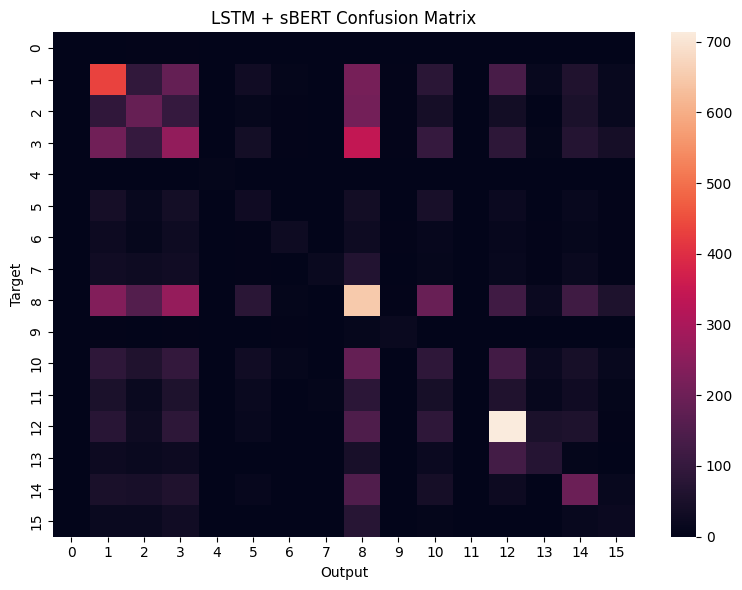

In [ ]:

plot_matrix(labels = labels, preds=predictions, name = 'LSTM + sBERT')